In [1]:
#时间序列分析
#常用算法：
#1.移动平均（MA, Moving Average）
#2.指数平滑（ES, Exponen-tialSmoothing）
#3.差分自回归移动平均模型（ARIMA, Auto-regressive Intergrated Moving Average Model）

In [2]:
import pandas as pd  # pandas库
import numpy as np  # numpy库
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # acf和pacf展示库
from statsmodels.tsa.stattools import adfuller  # adf检验库
from statsmodels.stats.diagnostic import acorr_ljungbox  # 随机性检验库
from statsmodels.tsa.arima_model import ARMA  # ARMA库
import matplotlib.pyplot as plt  # matplotlib图形展示库
#plt.use('TkAgg')
import prettytable  # 导入表格库


/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries modu

In [3]:
# 多次用到的表格
def pre_table(table_name, table_rows):
    '''
    :param table_name: 表格名称，字符串列表
    :param table_rows: 表格内容，嵌套列表
    :return: 展示表格对象
    '''
    table = prettytable.PrettyTable()  # 创建表格实例
    table.field_names = table_name  # 定义表格列名
    for i in table_rows:  # 循环读多条数据
        table.add_row(i)  # 增加数据
    return table


In [4]:
# 数据平稳处理
def get_best_log(ts, max_log=5, rule1=True, rule2=True):
    '''
    :param ts: 时间序列数据，Series类型
    :param max_log: 最大log处理的次数，int型
    :param rule1: rule1规则布尔值，布尔型
    :param rule2: rule2规则布尔值，布尔型
    :return: 达到平稳处理的最佳次数值和处理后的时间序列
    '''
    if rule1 and rule2:  # 如果两个规则同时满足
        return 0, ts  # 直接返回0和原始时间序列数据
    else:  # 只要有一个规则不满足
        for i in range(1, max_log):  # 循环做log处理
            ts = np.log(ts)  # log处理
            adf, pvalue1, usedlag, nobs, critical_values, icbest = adfuller(ts)  # 稳定性（ADF）检验
            lbvalue, pvalue2 = acorr_ljungbox(ts, lags=1)  # 白噪声（随机性）检验
            rule_1 = (adf < critical_values['1%'] and adf < critical_values['5%'] and adf < critical_values[
                '10%'] and pvalue1 < 0.01)  # 稳定性（ADF）检验规则
            rule_2 = (pvalue2 < 0.05)  # 白噪声（随机性）规则
            rule_3 = (i < 5)
            if rule_1 and rule_2 and rule_3:  # 如果同时满足条件
                print ('The best log n is: {0}'.format(i))  # 打印输出最佳次数
                return i, ts  # 返回最佳次数和处理后的时间序列


In [5]:
# 还原经过平稳处理的数据
def recover_log(ts, log_n):
    '''
    :param ts: 经过log方法平稳处理的时间序列，Series类型
    :param log_n: log方法处理的次数，int型
    :return: 还原后的时间序列
    '''
    for i in range(1, log_n + 1):  # 循环多次
        ts = np.exp(ts)  # log方法还原
    return ts  # 返回时间序列

In [6]:
# 稳定性（ADF）检验
def adf_val(ts, ts_title, acf_title, pacf_title):
    '''
    :param ts: 时间序列数据，Series类型
    :param ts_title: 时间序列图的标题名称，字符串
    :param acf_title: acf图的标题名称，字符串
    :param pacf_title: pacf图的标题名称，字符串
    :return: adf值、adf的p值、三种状态的检验值
    '''
    plt.figure()
    plt.plot(ts)  # 时间序列图
    plt.title(ts_title)  # 时间序列标题
    plt.show()
    plot_acf(ts, lags=20, title=acf_title).show()  # 自相关检测
    plot_pacf(ts, lags=20, title=pacf_title).show()  # 偏相关检测
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)  # 稳定性（ADF）检验
    table_name = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical_values', 'icbest']  # 表格列名列表
    table_rows = [[adf, pvalue, usedlag, nobs, critical_values, icbest]]  # 表格行数据，嵌套列表
    adf_table = pre_table(table_name, table_rows)  # 获得平稳性展示表格对象
    print ('stochastic score')  # 打印标题
    print (adf_table)  # 打印展示表格
    return adf, pvalue, critical_values,  # 返回adf值、adf的p值、三种状态的检验值

In [7]:
# 白噪声（随机性）检验
def acorr_val(ts):
    '''
    :param ts: 时间序列数据，Series类型
    :return: 白噪声检验的P值和展示数据表格对象
    '''
    lbvalue, pvalue = acorr_ljungbox(ts, lags=1)  # 白噪声检验结果
    table_name = ['lbvalue', 'pvalue']  # 表格列名列表
    table_rows = [[lbvalue, pvalue]]  # 表格行数据，嵌套列表
    acorr_ljungbox_table = pre_table(table_name, table_rows)  # 获得白噪声检验展示表格对象
    print ('stationarity score')  # 打印标题
    print (acorr_ljungbox_table)  # 打印展示表格
    return pvalue  # 返回白噪声检验的P值和展示数据表格对象

In [8]:
# arma最优模型训练
def arma_fit(ts):
    '''
    :param ts: 时间序列数据，Series类型
    :return: 最优状态下的p值、q值、arma模型对象、pdq数据框和展示参数表格对象
    '''
    max_count = int(len(ts) / 10)  # 最大循环次数最大定义为记录数的10%
    bic = float('inf')  # 初始值为正无穷
    tmp_score = []  # 临时p、q、aic、bic和hqic的值的列表
    for tmp_p in range(max_count + 1):  # p循环max_count+1次
        for tmp_q in range(max_count + 1):  # q循环max_count+1次
            model = ARMA(ts, order=(tmp_p, tmp_q))  # 创建ARMA模型对象
            try:
                results_ARMA = model.fit(disp=-1, method='css')  # ARMA模型训练
            except:
                continue  # 遇到报错继续
            finally:
                tmp_aic = results_ARMA.aic  # 模型的获得aic
                tmp_bic = results_ARMA.bic  # 模型的获得bic
                tmp_hqic = results_ARMA.hqic  # 模型的获得hqic
                tmp_score.append([tmp_p, tmp_q, tmp_aic, tmp_bic, tmp_hqic])  # 追加每个模型的训练参数和结果
                if tmp_bic < bic:  # 如果模型bic小于最小值，那么获得最优模型ARMA的下列参数：
                    p = tmp_p  # 最优模型ARMA的p值
                    q = tmp_q  # 最优模型ARMA的q值
                    model_arma = results_ARMA  # 最优模型ARMA的模型对象
                    aic = tmp_bic  # 最优模型ARMA的aic
                    bic = tmp_bic  # 最优模型ARMA的bic
                    hqic = tmp_bic  # 最优模型ARMA的hqic
    pdq_metrix = np.array(tmp_score)  # 将嵌套列表转换为矩阵
    pdq_pd = pd.DataFrame(pdq_metrix, columns=['p', 'q', 'aic', 'bic', 'hqic'])  # 基于矩阵创建数据框
    table_name = ['p', 'q', 'aic', 'bic', 'hqic']  # 表格列名列表
    table_rows = [[p, q, aic, bic, hqic]]  # 表格行数据，嵌套列表
    parameter_table = pre_table(table_name, table_rows)  # 获得最佳ARMA模型结果展示表格对象
    print ('each p/q traning record')  # 打印标题
    print (pdq_pd)  # 打印输出每次ARMA拟合结果，包含p、d、q以及对应的AIC、BIC、HQIC
    print ('best p and q')  # 打印标题
    print (parameter_table)  # 输出最佳ARMA模型结果展示表格对象
    return model_arma  # 最优状态下的arma模型对象

In [9]:
# 模型训练和效果评估
def train_test(model_arma, ts, log_n, rule1=True, rule2=True):
    '''
    :param model_arma: 最优ARMA模型对象
    :param ts: 时间序列数据，Series类型
    :param log_n: 平稳性处理的log的次数，int型
    :param rule1: rule1规则布尔值，布尔型
    :param rule2: rule2规则布尔值，布尔型
    :return: 还原后的时间序列
    '''
    train_predict = model_arma.predict()  # 得到训练集的预测时间序列
    if not (rule1 and rule2):  # 如果两个条件有任意一个不满足
        train_predict = recover_log(train_predict, log_n)  # 恢复平稳性处理前的真实时间序列值
        ts = recover_log(ts, log_n)  # 时间序列还原处理
    ts_data_new = ts[train_predict.index]  # 将原始时间序列数据的长度与预测的周期对齐
    RMSE = np.sqrt(np.sum((train_predict - ts_data_new) ** 2) / ts_data_new.size)  # 求RMSE
    # 对比训练集的预测和真实数据
    plt.figure()  # 创建画布
    train_predict.plot(label='predicted data', style='--')  # 以虚线展示预测数据
    ts_data_new.plot(label='raw data')  # 以实线展示原始数据
    plt.legend(loc='best')  # 设置图例位置
    plt.title('raw data and predicted data with RMSE of %.2f' % RMSE)  # 设置标题
    plt.show()  # 展示图像
    return ts  # 返回还原后的时间序列

In [10]:
# 模型训练和效果评估
def train_test(model_arma, ts, log_n, rule1=True, rule2=True):
    '''
    :param model_arma: 最优ARMA模型对象
    :param ts: 时间序列数据，Series类型
    :param log_n: 平稳性处理的log的次数，int型
    :param rule1: rule1规则布尔值，布尔型
    :param rule2: rule2规则布尔值，布尔型
    :return: 还原后的时间序列
    '''
    train_predict = model_arma.predict()  # 得到训练集的预测时间序列
    if not (rule1 and rule2):  # 如果两个条件有任意一个不满足
        train_predict = recover_log(train_predict, log_n)  # 恢复平稳性处理前的真实时间序列值
        ts = recover_log(ts, log_n)  # 时间序列还原处理
    ts_data_new = ts[train_predict.index]  # 将原始时间序列数据的长度与预测的周期对齐
    RMSE = np.sqrt(np.sum((train_predict - ts_data_new) ** 2) / ts_data_new.size)  # 求RMSE
    # 对比训练集的预测和真实数据
    plt.figure()  # 创建画布
    train_predict.plot(label='predicted data', style='--')  # 以虚线展示预测数据
    ts_data_new.plot(label='raw data')  # 以实线展示原始数据
    plt.legend(loc='best')  # 设置图例位置
    plt.title('raw data and predicted data with RMSE of %.2f' % RMSE)  # 设置标题
    plt.show()  # 展示图像
    return ts  # 返回还原后的时间序列

In [11]:
# 预测未来指定时间项的数据
def predict_data(model_arma, ts, log_n, start, end, rule1=True, rule2=True):
    '''
    :param model_arma: 最优ARMA模型对象
    :param ts: 时间序列数据，Series类型
    :param log_n: 平稳性处理的log的次数，int型
    :param start: 要预测数据的开始时间索引
    :param end: 要预测数据的结束时间索引
    :param rule1: rule1规则布尔值，布尔型
    :param rule2: rule2规则布尔值，布尔型
    :return: 无
    '''
    predict_ts = model_arma.predict(start=start, end=end)  # 预测未来指定时间项的数据
    print ('-----------predict data----------')  # 打印标题
    if not (rule1 and rule2):  # 如果两个条件有任意一个不满足
        predict_ts = recover_log(predict_ts, log_n)  # 还原数据
    print (predict_ts)  # 展示预测数据
    # 展示预测趋势
    plt.figure()  # 创建画布
    ts.plot(label='raw time series')  # 设置推向标签
    predict_ts.plot(label='predicted data', style='--')  # 以虚线展示预测数据
    plt.legend(loc='best')  # 设置图例位置
    plt.title('predicted time series')  # 设置标题
    plt.show()  # 展示图像


In [12]:
# 读取数据
date_parse = lambda dates: pd.datetime.strptime(dates, '%m-%d-%Y')  # 创建解析列的功能对象
df = pd.read_table('time_series.txt', delimiter='\t', index_col='date', date_parser=date_parse)  # 读取数据
ts_data = df['number'].astype('float32')  # 将列转换为float32类型
print ('data summary')  # 打印标题
print (ts_data.describe())  # 打印输出时间序列数据概况

data summary
count    149.000000
mean     164.382553
std       75.097740
min       47.000000
25%      100.000000
50%      156.000000
75%      201.000000
max      400.000000
Name: number, dtype: float64


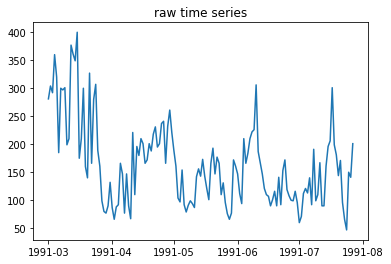

stochastic score
+---------------------+-----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
|         adf         |         pvalue        | usedlag | nobs |                                  critical_values                                  |       icbest       |
+---------------------+-----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
| -3.7642778196383406 | 0.0032946903802968273 |    11   | 137  | {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603} | 1405.3846604574503 |
+---------------------+-----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
stationarity score
+---------------+------------------+
|    lbvalue    |      pvalue      |
+---------------+------------------+
| [

/Users/liudawei/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


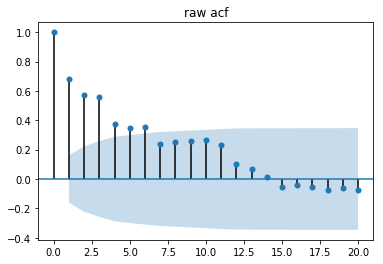

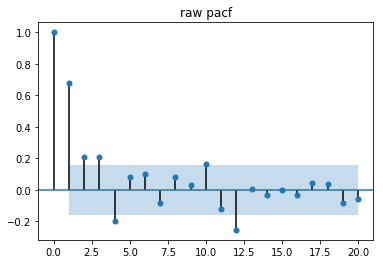

In [13]:
# 原始数据检验
adf, pvalue1, critical_values = adf_val(ts_data, 'raw time series', 'raw acf', 'raw pacf')  # 稳定性检验
pvalue2 = acorr_val(ts_data)  # 白噪声检验

In [14]:
# 创建用于区分是否进行平稳性处理的规则
rule1 = (adf < critical_values['1%'] and adf < critical_values['5%'] and adf < critical_values[
    '10%'] and pvalue1 < 0.01)  # 稳定性检验
rule2 = (pvalue2[0,] < 0.05)  # 白噪声检验

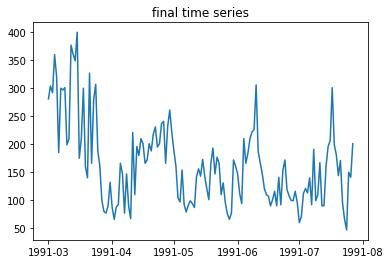

stochastic score
+---------------------+-----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
|         adf         |         pvalue        | usedlag | nobs |                                  critical_values                                  |       icbest       |
+---------------------+-----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
| -3.7642778196383406 | 0.0032946903802968273 |    11   | 137  | {'1%': -3.479007355368944, '5%': -2.8828782366015093, '10%': -2.5781488587564603} | 1405.3846604574503 |
+---------------------+-----------------------+---------+------+-----------------------------------------------------------------------------------+--------------------+
stationarity score
+---------------+------------------+
|    lbvalue    |      pvalue      |
+---------------+------------------+
| [

/Users/liudawei/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


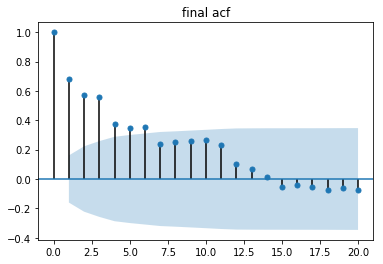

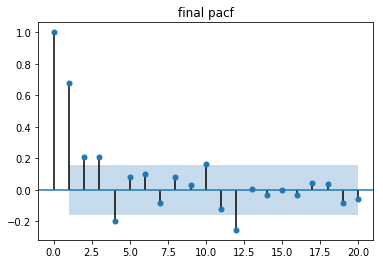

In [15]:
# 对时间序列做稳定性处理
log_n, ts_data = get_best_log(ts_data, max_log=5, rule1=rule1, rule2=rule2)
# 再次做检验
adf, pvalue1, critical_values = adf_val(ts_data, 'final time series', 'final acf', 'final pacf')  # 稳定性检验
pvalue2 = acorr_val(ts_data)  # 白噪声检验

In [16]:
# 训练最佳ARMA模型并输出相关参数和对象
model_arma = arma_fit(ts_data)

/Users/liudawei/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1364: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/liudawei/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1367: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/liudawei/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:1373: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future th

/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood opti

each p/q traning record
        p     q          aic          bic         hqic
0     0.0   0.0  1712.839862  1718.847755  1715.280770
1     0.0   1.0  1653.446702  1662.458541  1657.108063
2     0.0   2.0  1648.868523  1660.884308  1653.750338
3     0.0   3.0  1618.676555  1633.696287  1624.778824
4     0.0   4.0  1619.720071  1637.743748  1627.042793
5     0.0   5.0  1619.720071  1637.743748  1627.042793
6     0.0   6.0  1601.914727  1625.946297  1611.678357
7     0.0   7.0  1603.490230  1630.525746  1614.474313
8     0.0   8.0  1603.310918  1633.350381  1615.515455
9     0.0   9.0  1605.309821  1638.353230  1618.734812
10    0.0  10.0  1605.309821  1638.353230  1618.734812
11    0.0  11.0  1605.309821  1638.353230  1618.734812
12    0.0  12.0  1605.309821  1638.353230  1618.734812
13    0.0  13.0  1605.309821  1638.353230  1618.734812
14    0.0  14.0  1605.309821  1638.353230  1618.734812
15    1.0   0.0  1607.860643  1616.852280  1611.513924
16    1.0   1.0  1597.519474  1609.508323

/Users/liudawei/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


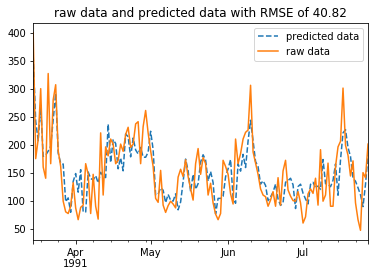

In [17]:
# 模型训练和效果评估
ts_data = train_test(model_arma, ts_data, log_n, rule1=rule1, rule2=rule2)

-----------predict data----------
1991-07-28    184.701170
1991-07-29    126.560639
1991-07-30    133.453608
1991-07-31    140.613457
1991-08-01    106.698398
1991-08-02    109.758543
Freq: D, dtype: float64


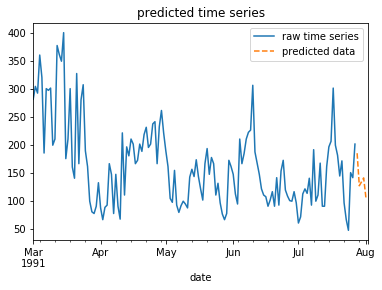

In [18]:
# 模型预测应用
start = '1991-07-28'  # 设置预测开始的时间索引
end = '1991-08-02'  # 设置预测结束的时间索引
predict_data(model_arma, ts_data, log_n, start, end, rule1=rule1, rule2=rule2)  # 预测时间序列数据